In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import cufflinks as cf
#cf.go_offline()
import warnings 
warnings.filterwarnings('ignore')
from matplotlib import rcParams
from _plotly_future_ import v4_subplots

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

import plotly as pl
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import sklearn

import sklearn.linear_model as linear_model
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import HTML, display
import category_encoders
pd.options.display.max_columns = None
import missingno as msno
from numpy.random import choice
np.random.seed(99)

In [2]:
df_demo=pd.read_csv('Data\DEMO_I.csv')
df_bmi=pd.read_csv('Data\BMX_I.csv')
df_bmi=df_bmi[['SEQN','BMXBMI']]

In [3]:
df=pd.merge(df_demo,df_bmi,how="inner",on='SEQN')

In [4]:
columns_used=[ 'RIAGENDR', 'RIDAGEYR','RIDRETH3', 'DMQMILIZ','DMDBORN4', 'DMDCITZN', 'DMDEDUC3','DMDEDUC2', 'DMDMARTL',
'RIDEXPRG', 'SIALANG', 'SIAPROXY','SIAINTRP', 'MIALANG',
 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'BMXBMI']

In [5]:
df=df[columns_used]
df = df[np.isfinite(df['BMXBMI'])]

In [6]:
#change the columns names
columns=df.columns.values
map_column_names={}

new_column_names=['p_gen','p_yr','p_race','p_milt','p_born',
                  'p_citz','p_edu619','p_edu20','p_marl','p_pre','p_ilang',
                 'p_iprox','p_intrp','mec_lang','mec_prox','mec_intrp','aca_lang','bmi']

orig_column_names=[each for each in columns if each in columns_used]

for step,col in enumerate(orig_column_names):
    map_column_names[new_column_names[step]]=col

if len(new_column_names)==len(df.columns.values):
    df.columns=new_column_names
print(map_column_names)

{'p_gen': 'RIAGENDR', 'p_yr': 'RIDAGEYR', 'p_race': 'RIDRETH3', 'p_milt': 'DMQMILIZ', 'p_born': 'DMDBORN4', 'p_citz': 'DMDCITZN', 'p_edu619': 'DMDEDUC3', 'p_edu20': 'DMDEDUC2', 'p_marl': 'DMDMARTL', 'p_pre': 'RIDEXPRG', 'p_ilang': 'SIALANG', 'p_iprox': 'SIAPROXY', 'p_intrp': 'SIAINTRP', 'mec_lang': 'MIALANG', 'mec_prox': 'MIAPROXY', 'mec_intrp': 'MIAINTRP', 'aca_lang': 'AIALANGA', 'bmi': 'BMXBMI'}


In [7]:
# change the row values according to the names 
#categroical non ordinal
#gender 1 [map male and female]
df['p_gen'].replace({1:'male',2:'female'},inplace=True)
df['p_gen'].unique()


array(['male', 'female'], dtype=object)

In [8]:
#year 2 [no change]
#race map the race/ethnicity
#categorical non ordinal
df['p_race'].replace({1:'his_mex_americans',2:'his_others',
                      3:'nhis_white',4:'nhis_black',
                      6:'nhis_asian',7:'nhis_others'},inplace=True)
df['p_race'].unique()

array(['nhis_white', 'nhis_black', 'his_mex_americans', 'nhis_asian',
       'nhis_others', 'his_others'], dtype=object)

In [9]:
#miltitary mapping
#categorical non ordinal
df['p_milt'].replace({1.0:'mil_yes',2.0:'mil_no',np.nan:'mil_missing'},inplace=True)
df['p_milt'].unique()

array(['mil_no', 'mil_yes', 'mil_missing'], dtype=object)

In [10]:
#born in county
#categorical non ordinal
df['p_born'].replace({1:'born_us',2:'born_not_us',77:'born_missing',99.:'born_missing'},inplace=True)
df['p_born'].unique()

array(['born_us', 'born_not_us', 'born_missing'], dtype=object)

In [11]:
#citizen
#categorical non ordinal
df['p_citz'].replace({1.:'yes_citz',2.:'not_citz',9.:'citz_missing',7.:'citz_missing',np.nan:'citz_missing'},inplace=True)
df['p_citz'].unique()

array(['yes_citz', 'not_citz', 'citz_missing'], dtype=object)

In [12]:
mask=df['p_gen']=='male'
df.loc[mask,'p_pre']=2.0
mask1=((df['p_yr']<18.0) & df['p_pre'].isna())
df.loc[mask1,'p_pre']=2.0
df.loc[df['p_pre'].isna(),'p_pre']=3.0

df['p_pre'].replace({1.0:'p_preg',2.0:'p_not_preg',3.0:'p_preg_dont'},inplace=True)

In [13]:
#marital status
#categorical non ordinal 
df['p_marl'].replace({1.:'p_married',2.:'p_widowed',3.:'p_divorced',
                      4.:'p_separated',5.:'p_never_married',6.:'p_liv_partn',
                     77.:'p_martl_missing',99.:'p_martl_missing',np.nan:'p_martl_missing'},inplace=True)
df['p_marl'].unique()

array(['p_married', 'p_divorced', 'p_liv_partn', 'p_separated',
       'p_martl_missing', 'p_never_married', 'p_widowed'], dtype=object)

In [14]:
#person lanuage spoke in interview
#categorical non ordinal
df['p_ilang'].replace({1:'p_eng_lang_int',2:'p_spa_lang_int'},inplace=True)
df['p_ilang'].unique()

array(['p_eng_lang_int', 'p_spa_lang_int'], dtype=object)

In [15]:
#proxy respondent during interview
#categorical non ordinal
df['p_iprox'].replace({1.:'p_prox_res_yes',2.:'p_prox_res_no',np.nan:'p_prox_res_missing'},inplace=True)
df['p_iprox'].unique()

array(['p_prox_res_no', 'p_prox_res_yes', 'p_prox_res_missing'],
      dtype=object)

In [16]:
#interpreter during the interview
#categorical non ordinal
df['p_intrp'].replace({1:'p_intrp_yes',2.:'p_intrp_no'},inplace=True)
df['p_intrp'].unique()

array(['p_intrp_no', 'p_intrp_yes'], dtype=object)

In [17]:
#mec language interview 
#categorical non ordinal
df['mec_lang'].replace({1.:'mec_lang_eng',2.:'mec_lang_spa',np.nan:'mec_lang_missing'},inplace=True)
df['mec_lang'].unique()

array(['mec_lang_eng', 'mec_lang_missing', 'mec_lang_spa'], dtype=object)

In [18]:
#mec proxy respondent
#categorical non ordinal
df['mec_prox'].replace({1.:'mec_prox_yes',2.:'mec_prox_no',np.nan:'mec_prox_missing'},inplace=True)
df['mec_prox'].unique()


array(['mec_prox_no', 'mec_prox_missing', 'mec_prox_yes'], dtype=object)

In [19]:
#mec interpreter 
#categorical non ordinal
df['mec_intrp'].replace({1.:'mec_intrp_yes',2.:'mec_intrp_no',np.nan:'mec_intrp_missing'},inplace=True)
df['mec_intrp'].unique()

array(['mec_intrp_no', 'mec_intrp_missing', 'mec_intrp_yes'], dtype=object)

In [20]:
#aca lang interview
#categorical non ordinal
df['aca_lang'].replace({1.:'aca_lan_int_eng',2.:'aca_lan_int_spa',3.:'aca_lan_int_asi',np.nan:'aca_lan_int_missing'},inplace=True)
df['aca_lang'].unique()

array(['aca_lan_int_eng', 'aca_lan_int_missing', 'aca_lan_int_asi',
       'aca_lan_int_spa'], dtype=object)

In [21]:

df.loc[df['p_edu619'].isna(),'p_edu619']=-1
df["p_edu619"] = df.p_edu619.astype(int)
df.loc[df['p_edu20'].isna(),'p_edu20']=-1
df["p_edu20"] = df.p_edu20.astype(int)
df.loc[df['p_edu619']==66,'p_edu619']=5
df.loc[df['p_yr']==2.0,'p_edu619']=0
df.loc[df['p_yr']==3.0,'p_edu619']=0
df.loc[df['p_yr']==4.0,'p_edu619']=0
df.loc[df['p_yr']==5.0,'p_edu619']=0
df.loc[df['p_edu619']==55,'p_edu619']=3
df.loc[df['p_edu619']==99,'p_edu619']=5
df['p_edu20'].replace({1:5,2:10,3:13,4:16,5:17},inplace=True)
df.loc[df['p_edu619']==-1,'p_edu619']=df[df['p_edu619']==-1]['p_edu20']
df.loc[df['p_edu619']==-1,'p_edu619']=0
df.groupby(['p_yr']).agg({'p_edu619':[np.min,np.max,np.mean]}).head()
df.drop(columns=['p_edu20'],inplace=True)
df.rename(columns={'p_edu619': 'p_edu'}, inplace=True)

In [22]:
def columns_int_obj_flo(df):

    intcol=[]
    flcol=[]
    obcol=[]
    for each in df.columns.values:
        if type(df[each][0])==np.int64:
            intcol.append(each)
        elif type(df[each][0])==np.float64:
            flcol.append(each)
        else:
            obcol.append(each)
    return intcol,flcol,obcol

intcol,flcol,obcol=columns_int_obj_flo(df)

In [23]:
#data exploration, look for way to fill missing values
for each in obcol+flcol:
    tempdf=df[each].value_counts().reset_index()
    fig = go.Figure(data=[go.Pie(labels=tempdf['index'],values=tempdf[each],hole=0.3)])
    fig.update_layout(height=350, showlegend=True)
    fig.update_layout(title_text=each,margin=dict(l=25, r=20, t=35, b=20))
    fig.show()




In [24]:
# since for people age less then 20 years was not shown , we will take it as never married with some bias, even though if they
#were married
df.loc[df['p_yr']<20.0,'p_marl']='p_never_married'

In [25]:
#remove the dropped columns
intcol,flcol,obcol=columns_int_obj_flo(df)

In [26]:
for each in obcol:
    if each in df.columns.values:
        df.loc[df[each].str.contains('missing'),each]=np.nan

In [27]:
#none of the intcolumns have nan values [good sign]
np.sum(df[intcol]==-1.0)

p_edu    0
dtype: int64

In [28]:
colwithna=pd.DataFrame(np.sum(df[flcol]==-1.0)>1)
for each in list(colwithna[colwithna[0]==True].index):
    df.loc[df[each]==-1.0,each]=np.nan

In [29]:
df.isna().sum()

p_gen           0
p_yr            0
p_race          0
p_milt       2943
p_born          2
p_citz         15
p_edu           0
p_marl          2
p_pre           0
p_ilang         0
p_iprox         1
p_intrp         0
mec_lang     1850
mec_prox     1849
mec_intrp    1849
aca_lang     2841
bmi             0
dtype: int64

In [30]:
columns_with_na=df.columns[df.isna().any()].tolist()

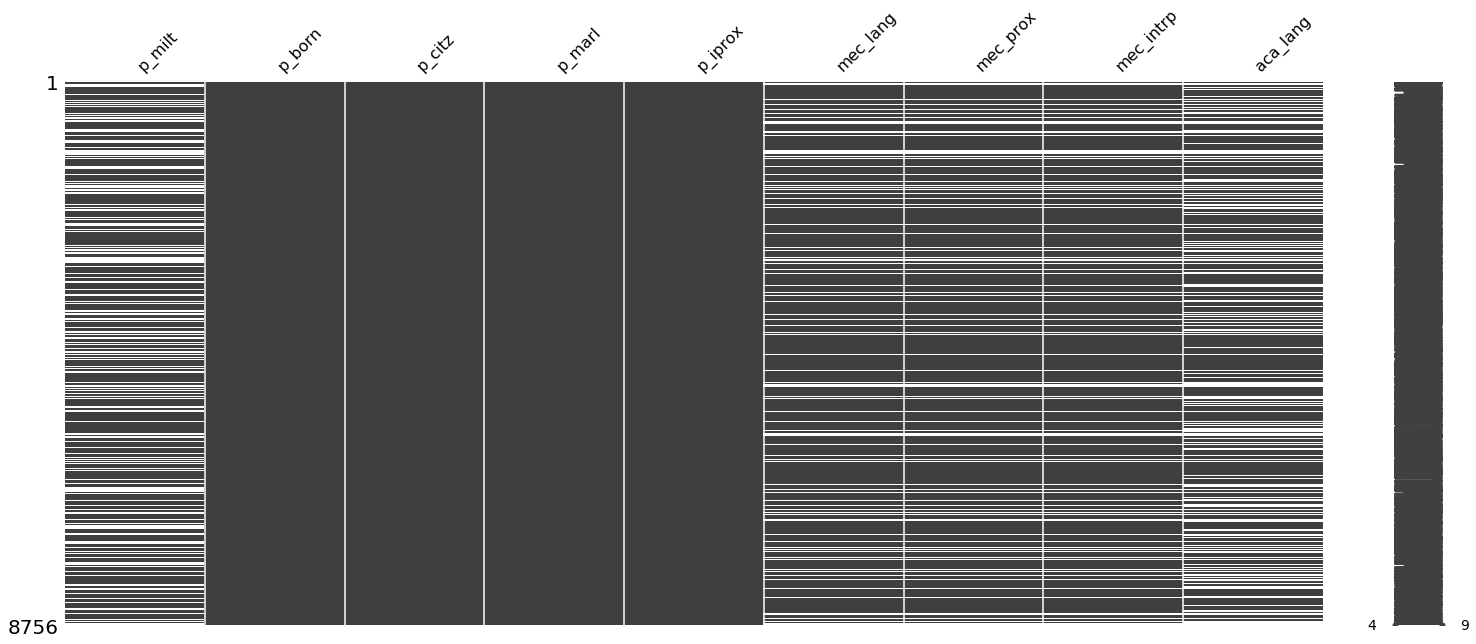

In [31]:
msno.matrix(df[columns_with_na])

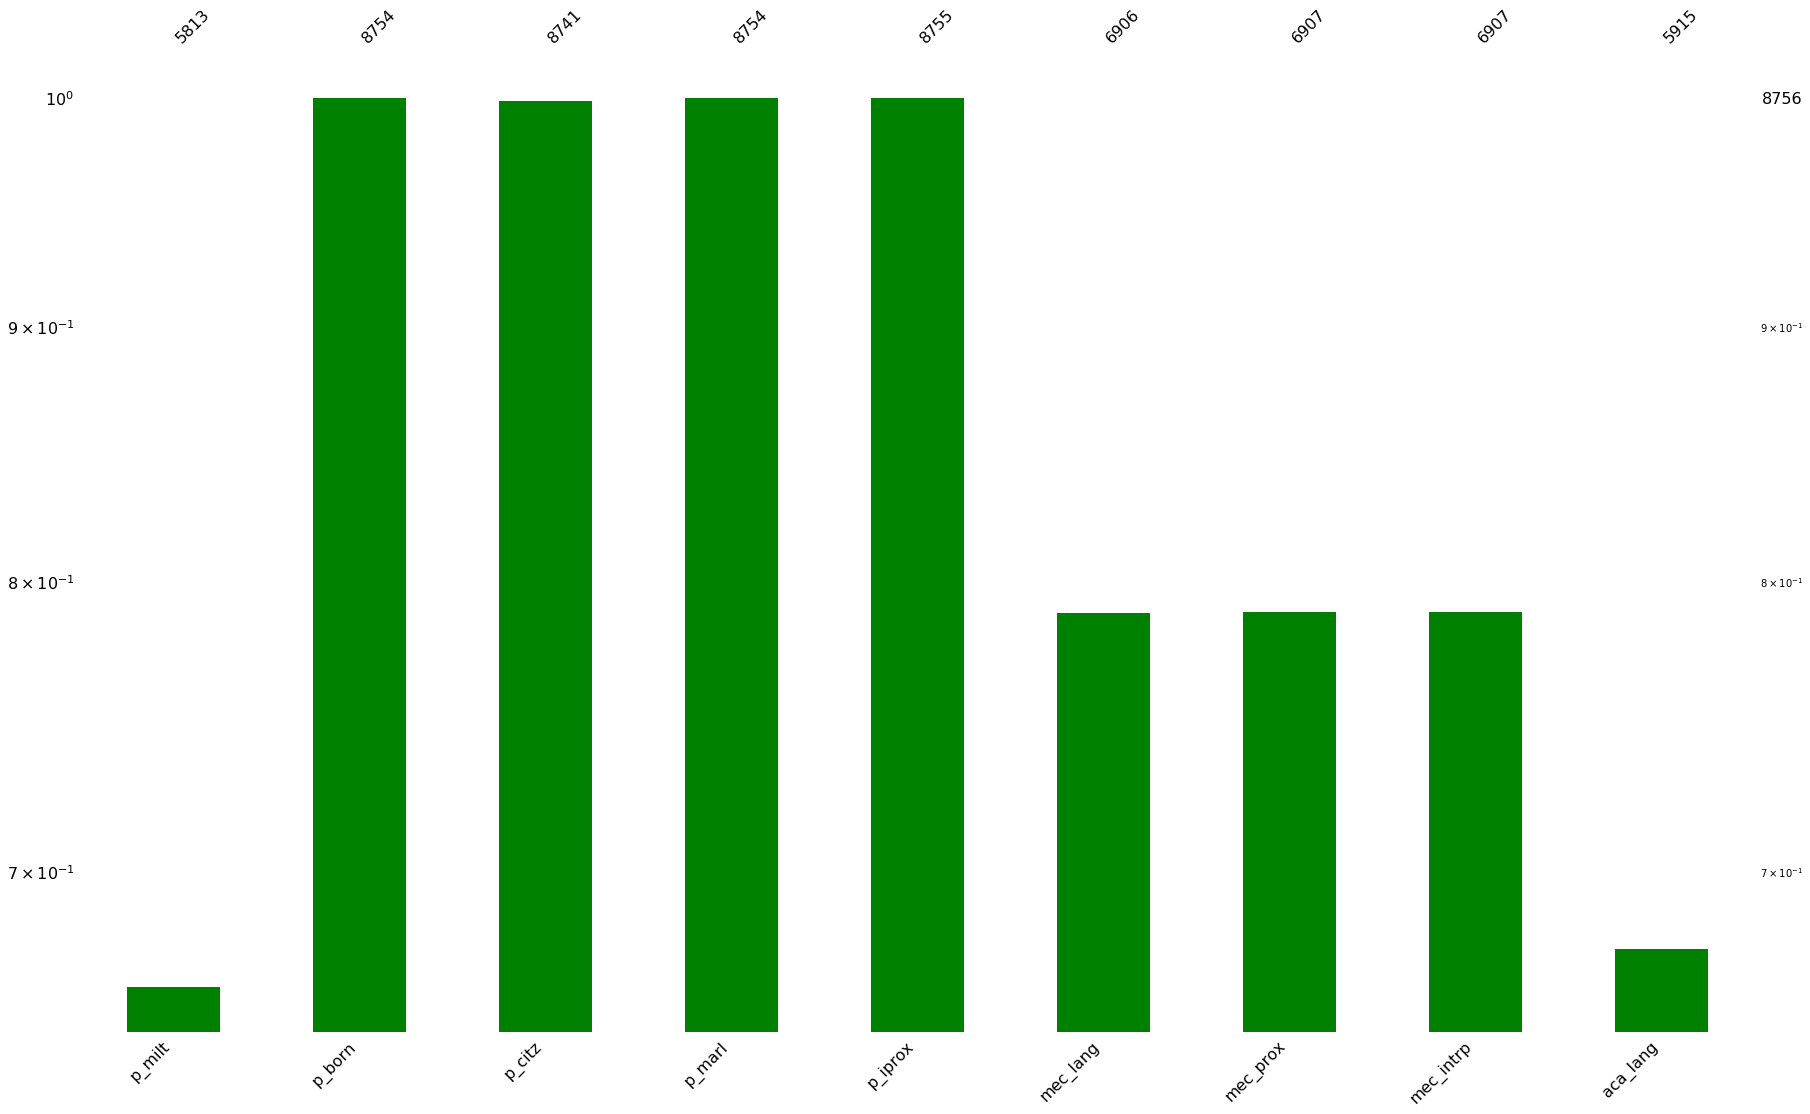

In [32]:
msno.bar(df[columns_with_na], color="green", log=True, figsize=(30,18))

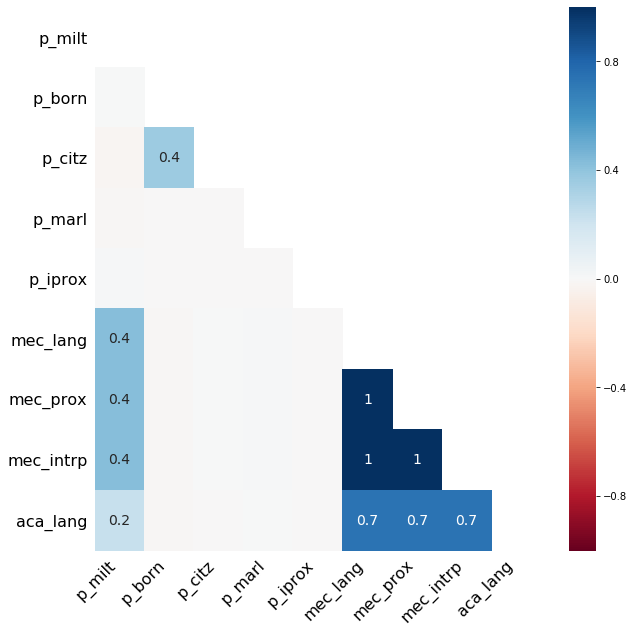

In [33]:
''' a simple correlation heatmap is shown below. 
map describes the degree of nullity relationship between the different features. 
The range of this nullity correlation is from -1 to 1  
Features with no missing value are excluded in the heatmap. 
If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed.
Also, a perfect positive nullity correlation (R=1) indicates when the first feature and the second feature both have 
corresponding missing values while a perfect negative nullity correlation (R=-1) 
means that one of the features is missing and the second is not missing.'''
'''summarizing if R=1 then first and second feature both have corresponding missing values'''
'''summarizing if R=-1 then one is missing and other one is not missing'''

msno.heatmap(df[columns_with_na], figsize=(10,10))

In [34]:
def dictcountna(df):
    columns_with_na=df.columns[df.isna().any()].tolist()
    dict_count_na=dict(df[columns_with_na].isna().sum())
    sorted_dict_count_na={}
    for each in sorted(dict_count_na.items(),key=lambda x:x[1]):
        sorted_dict_count_na[each[0]]=each[1]
    
    return dict_count_na,sorted_dict_count_na

In [35]:
dict_count_na,sorted_dict_count_na=dictcountna(df)

In [36]:
#manually impute values by checking the similarity among other records [nearest neighbours] 
#basically clustering similar records


#select those columns which can give a sense of filling the values which are missing
def neighbours_similarity(proxycolumns,variable,df,dict_count_na):
    #find records where variable is not null
    piproxdfnotnull=df[df[variable].notnull()][proxycolumns].T.reset_index()
    p_iproxnotnull={}
    listnotnull=[list(each.values()) for each in piproxdfnotnull.to_dict('records')]
    for each in listnotnull:
        p_iproxnotnull[each[0]]=each[1:]

    #find records where variable is null
    piproxdfnull=df[df[variable].isnull()][proxycolumns].T.reset_index()
    p_iproxnull={}
    listnull=[list(each.values()) for each in piproxdfnull.to_dict('records')]
    for each in listnull:
        p_iproxnull[each[0]]=each[1:]


    #records a sparse matrices for all the rows with similairty excluding the ones which is NA
    #check for atleast one null record
    if piproxdfnull.shape[1]>1:
        for step in range(dict_count_na[variable]):
            matallrecnotnull=np.empty((0,len(df)-dict_count_na[variable]))
            for k,v in zip(p_iproxnull.items(),p_iproxnotnull.items()):

                if not k[0]==variable:
                    matallrecnotnull=np.append(matallrecnotnull,np.array([[1 if each==k[1][step] else 0 for i,each in enumerate(v[1])]]),axis=0)

            rows_for_intersect=[]
            for i in range(matallrecnotnull.shape[0]):
                rows_for_intersect.append(np.where(matallrecnotnull[i,:])[0])

            #number of NA's in the original dataset
            fin=[each for each in set.intersection(*map(set, rows_for_intersect))]
            #do average  of the results expected and assign it back to the original data frame

            tempdf=df.drop(piproxdfnull.columns.values[1:]).reset_index()
            resultobtained=tempdf.loc[fin][variable].value_counts().reset_index().sort_values(by=[variable])['index']
            index_to_be_set=piproxdfnull.columns.values[step+1]
            if resultobtained.any():
                print(index_to_be_set,resultobtained[0])
                df.loc[index_to_be_set,variable]=resultobtained[0]
            else:
                print(index_to_be_set,df[variable].mode()[0],"modeused")
                df.loc[index_to_be_set,variable]=df[variable].mode()[0]
    return df


In [37]:
list(sorted_dict_count_na.items())

newdf=df.copy()

In [38]:
dict_count_na,sorted_dict_count_na=dictcountna(newdf)
# start with columns which have have lowest NA's
#iprox
neighbours=['p_gen','p_born','p_yr']
variable='p_iprox'
newdf=neighbours_similarity(neighbours,variable,newdf,dict_count_na)

1944 p_prox_res_yes


In [39]:
dict_count_na,sorted_dict_count_na=dictcountna(newdf)
neighbours=[ 'p_gen','p_ilang','p_iprox','p_yr']
variable='p_born'
newdf=neighbours_similarity(neighbours,variable,newdf,dict_count_na)


2933 born_us
8426 born_not_us


In [40]:
dict_count_na,sorted_dict_count_na=dictcountna(newdf)
neighbours=['p_gen','p_born','p_intrp','p_yr']
variable ='p_citz'
newdf=neighbours_similarity(neighbours,variable,newdf,dict_count_na)

355 yes_citz
696 not_citz
899 not_citz
1273 yes_citz
1540 not_citz
2736 not_citz
2933 yes_citz
5107 yes_citz
5823 yes_citz
5849 not_citz
7375 not_citz
8426 yes_citz
8539 not_citz
8677 not_citz
9448 not_citz


In [41]:
newdf.loc[1702,'p_marl']='p_never_married'
newdf.loc[6608,'p_marl']=' p_liv_partn'

In [42]:
#look back all the columns to fill the from forward missing columns
#now do a similarity algorithm to fill those missing values
# now use previous columns to fill the front columns
dict_count_na,sorted_dict_count_na=dictcountna(newdf)
neighbours=['p_ilang','p_iprox','p_intrp','p_born','p_gen']
variable ='mec_lang'
newdf=neighbours_similarity(neighbours,variable,newdf,dict_count_na)


7 mec_lang_eng
11 mec_lang_eng
14 mec_lang_eng
16 mec_lang_eng
27 mec_lang_eng
29 mec_lang_eng
30 mec_lang_eng
38 mec_lang_eng
42 mec_lang_eng
46 mec_lang_eng
51 mec_lang_eng
57 mec_lang_eng
60 mec_lang_eng
61 mec_lang_eng
64 mec_lang_eng
67 mec_lang_eng
68 mec_lang_eng
70 mec_lang_eng
71 mec_lang_eng
73 mec_lang_eng
75 mec_lang_eng
76 mec_lang_eng
88 mec_lang_spa
89 mec_lang_eng
91 mec_lang_eng
106 mec_lang_eng
116 mec_lang_eng
122 mec_lang_eng
126 mec_lang_eng
135 mec_lang_eng
136 mec_lang_spa
143 mec_lang_eng
149 mec_lang_eng
153 mec_lang_eng
166 mec_lang_eng
168 mec_lang_eng
193 mec_lang_eng
196 mec_lang_eng
225 mec_lang_eng
230 mec_lang_eng
240 mec_lang_eng
241 mec_lang_eng
248 mec_lang_eng
255 mec_lang_eng
267 mec_lang_eng
272 mec_lang_eng
278 mec_lang_eng
281 mec_lang_eng
290 mec_lang_eng
296 mec_lang_eng
308 mec_lang_eng
310 mec_lang_eng
317 mec_lang_eng
324 mec_lang_spa
333 mec_lang_eng
339 mec_lang_eng
340 mec_lang_eng
343 mec_lang_eng
345 mec_lang_eng
354 mec_lang_eng
361 me

2535 mec_lang_eng
2537 mec_lang_eng
2541 mec_lang_eng
2544 mec_lang_eng
2547 mec_lang_eng
2549 mec_lang_eng
2553 mec_lang_eng
2563 mec_lang_eng
2571 mec_lang_eng
2578 mec_lang_eng
2579 mec_lang_eng
2581 mec_lang_eng
2583 mec_lang_eng
2587 mec_lang_eng
2595 mec_lang_eng
2596 mec_lang_eng
2597 mec_lang_eng
2601 mec_lang_eng
2607 mec_lang_eng
2614 mec_lang_spa
2617 mec_lang_eng
2623 mec_lang_eng
2628 mec_lang_spa
2636 mec_lang_eng
2638 mec_lang_eng
2649 mec_lang_eng
2650 mec_lang_eng
2654 mec_lang_eng
2655 mec_lang_eng
2656 mec_lang_eng
2657 mec_lang_eng
2661 mec_lang_eng
2678 mec_lang_eng
2684 mec_lang_eng
2695 mec_lang_spa
2700 mec_lang_eng
2706 mec_lang_eng
2709 mec_lang_eng
2711 mec_lang_eng
2726 mec_lang_eng
2735 mec_lang_eng
2736 mec_lang_eng
2737 mec_lang_eng
2745 mec_lang_eng
2753 mec_lang_eng
2759 mec_lang_eng
2760 mec_lang_eng
2769 mec_lang_eng
2776 mec_lang_eng
2777 mec_lang_eng
2779 mec_lang_eng
2780 mec_lang_eng
2791 mec_lang_eng
2792 mec_lang_eng
2796 mec_lang_eng
2802 mec_l

4838 mec_lang_eng
4843 mec_lang_eng
4847 mec_lang_eng
4852 mec_lang_eng
4854 mec_lang_eng
4859 mec_lang_eng
4860 mec_lang_spa
4861 mec_lang_eng
4863 mec_lang_eng
4866 mec_lang_eng
4868 mec_lang_eng
4876 mec_lang_eng
4884 mec_lang_eng
4890 mec_lang_eng
4906 mec_lang_eng
4914 mec_lang_eng
4931 mec_lang_eng
4946 mec_lang_eng
4952 mec_lang_eng
4959 mec_lang_eng
4973 mec_lang_eng
4975 mec_lang_eng
4980 mec_lang_spa
4981 mec_lang_eng
4990 mec_lang_eng
4991 mec_lang_eng
4992 mec_lang_eng
4995 mec_lang_eng
5001 mec_lang_eng
5007 mec_lang_eng
5008 mec_lang_eng
5011 mec_lang_eng
5015 mec_lang_eng
5018 mec_lang_eng
5020 mec_lang_eng
5024 mec_lang_eng
5027 mec_lang_eng
5028 mec_lang_eng
5040 mec_lang_eng
5045 mec_lang_eng
5049 mec_lang_eng
5054 mec_lang_eng
5056 mec_lang_eng
5070 mec_lang_eng
5076 mec_lang_eng
5084 mec_lang_eng
5085 mec_lang_eng
5088 mec_lang_eng
5096 mec_lang_eng
5100 mec_lang_eng
5110 mec_lang_eng
5112 mec_lang_eng
5114 mec_lang_eng
5122 mec_lang_spa
5123 mec_lang_eng
5129 mec_l

7135 mec_lang_eng
7136 mec_lang_eng
7138 mec_lang_eng
7144 mec_lang_eng
7148 mec_lang_eng
7171 mec_lang_eng
7172 mec_lang_spa
7179 mec_lang_eng
7181 mec_lang_eng
7183 mec_lang_eng
7189 mec_lang_eng
7190 mec_lang_eng
7200 mec_lang_eng
7210 mec_lang_eng
7221 mec_lang_eng
7232 mec_lang_eng
7240 mec_lang_eng
7241 mec_lang_eng
7247 mec_lang_spa
7255 mec_lang_eng
7257 mec_lang_eng
7265 mec_lang_eng
7283 mec_lang_eng
7285 mec_lang_eng
7290 mec_lang_eng
7293 mec_lang_eng
7298 mec_lang_eng
7303 mec_lang_eng
7310 mec_lang_eng
7314 mec_lang_eng
7315 mec_lang_eng
7316 mec_lang_eng
7320 mec_lang_eng
7322 mec_lang_eng
7324 mec_lang_eng
7327 mec_lang_eng
7335 mec_lang_eng
7345 mec_lang_spa
7349 mec_lang_eng
7354 mec_lang_eng
7363 mec_lang_eng
7365 mec_lang_eng
7368 mec_lang_eng
7371 mec_lang_eng
7393 mec_lang_eng
7396 mec_lang_eng
7398 mec_lang_eng
7400 mec_lang_eng
7401 mec_lang_eng
7402 mec_lang_eng
7405 mec_lang_eng
7407 mec_lang_eng
7415 mec_lang_eng
7421 mec_lang_eng
7427 mec_lang_eng
7434 mec_l

9501 mec_lang_eng
9508 mec_lang_eng
9515 mec_lang_eng
9523 mec_lang_eng
9524 mec_lang_eng
9534 mec_lang_eng
9535 mec_lang_eng
9540 mec_lang_eng
9541 mec_lang_eng


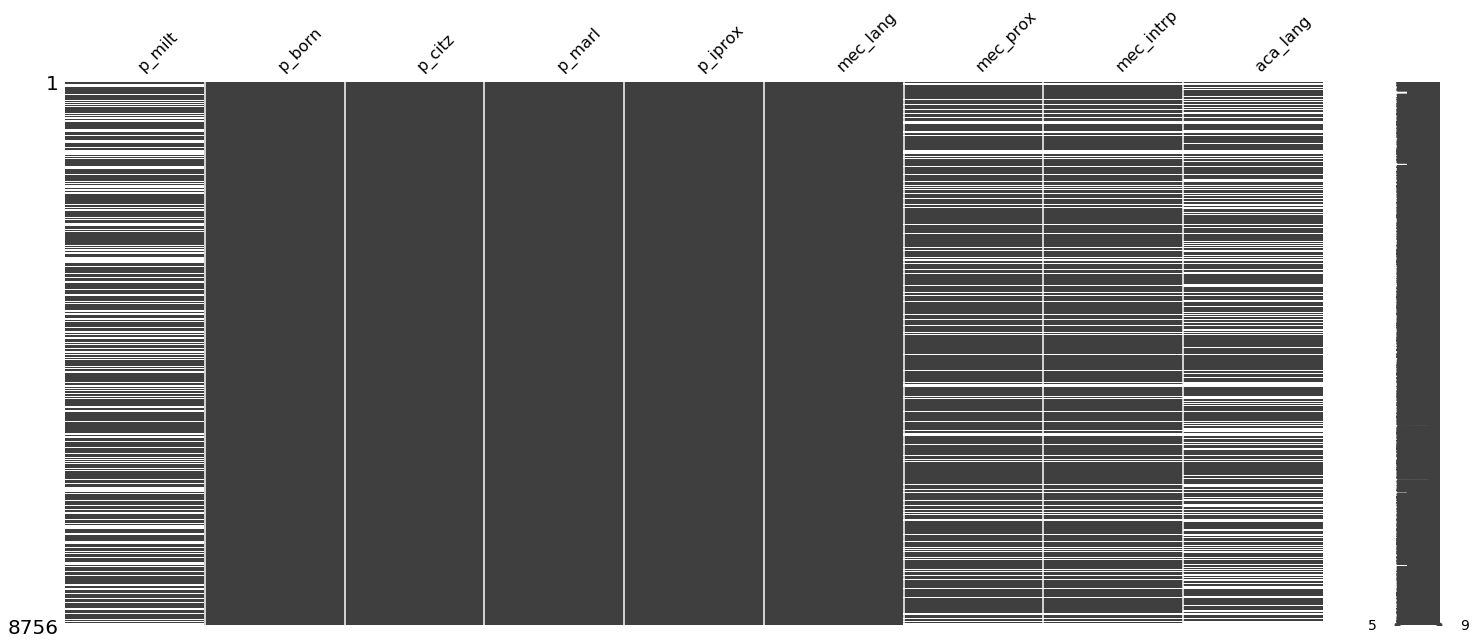

In [43]:
columns_with_na=newdf.columns[df.isna().any()].tolist()
msno.matrix(newdf[columns_with_na])

In [44]:
#look back all the columns to fill the from forward missing columns
#now do a similarity algorithm to fill those missing values
# now use previous columns to fill the front columns
dict_count_na,sorted_dict_count_na=dictcountna(newdf)
neighbours=['p_ilang','p_iprox','p_intrp','p_born','p_gen','mec_lang']
variable ='mec_prox'
newdf=neighbours_similarity(neighbours,variable,newdf,dict_count_na)


7 mec_prox_no
11 mec_prox_no
14 mec_prox_no
16 mec_prox_no
27 mec_prox_no
29 mec_prox_no
30 mec_prox_no
38 mec_prox_no
42 mec_prox_no
46 mec_prox_no
51 mec_prox_no
57 mec_prox_no
60 mec_prox_no
61 mec_prox_no
64 mec_prox_no
67 mec_prox_no
68 mec_prox_no
70 mec_prox_no
71 mec_prox_no
73 mec_prox_no
75 mec_prox_no
76 mec_prox_no
88 mec_prox_no
89 mec_prox_no
91 mec_prox_no
106 mec_prox_no
116 mec_prox_no
122 mec_prox_no
126 mec_prox_no
135 mec_prox_no
136 mec_prox_no
143 mec_prox_no
149 mec_prox_no
153 mec_prox_no
166 mec_prox_no
168 mec_prox_no
193 mec_prox_no
196 mec_prox_no
225 mec_prox_no
230 mec_prox_no
240 mec_prox_no
241 mec_prox_no
248 mec_prox_no
255 mec_prox_no
267 mec_prox_no
272 mec_prox_no
278 mec_prox_no
281 mec_prox_no
290 mec_prox_no
296 mec_prox_no
308 mec_prox_no
310 mec_prox_no
317 mec_prox_no
324 mec_prox_no
333 mec_prox_no
339 mec_prox_no
340 mec_prox_no
343 mec_prox_no
345 mec_prox_no
354 mec_prox_no
361 mec_prox_no
379 mec_prox_no
380 mec_prox_no
381 mec_prox_no
39

2678 mec_prox_no
2684 mec_prox_no
2695 mec_prox_no
2700 mec_prox_no
2706 mec_prox_no
2709 mec_prox_no
2711 mec_prox_no
2726 mec_prox_no
2735 mec_prox_no
2736 mec_prox_no
2737 mec_prox_no
2745 mec_prox_no
2753 mec_prox_no
2759 mec_prox_no
2760 mec_prox_no
2769 mec_prox_no
2776 mec_prox_no
2777 mec_prox_no
2779 mec_prox_no
2780 mec_prox_no
2791 mec_prox_no
2792 mec_prox_no
2796 mec_prox_no
2802 mec_prox_no
2811 mec_prox_no
2831 mec_prox_no
2832 mec_prox_no
2834 mec_prox_no
2840 mec_prox_no
2845 mec_prox_no
2850 mec_prox_no
2863 mec_prox_no
2866 mec_prox_no
2874 mec_prox_no
2875 mec_prox_no
2890 mec_prox_no
2895 mec_prox_no
2898 mec_prox_no
2900 mec_prox_no
2902 mec_prox_no
2909 mec_prox_no
2910 mec_prox_no
2926 mec_prox_no
2932 mec_prox_no
2940 mec_prox_no
2943 mec_prox_no
2959 mec_prox_no
2962 mec_prox_no
2963 mec_prox_no
2967 mec_prox_no
2972 mec_prox_no
2976 mec_prox_no
2980 mec_prox_no
2982 mec_prox_no
2985 mec_prox_no
2992 mec_prox_no
2994 mec_prox_no
2997 mec_prox_no
2999 mec_prox_

5151 mec_prox_no
5154 mec_prox_no
5166 mec_prox_no
5168 mec_prox_no
5169 mec_prox_no
5171 mec_prox_no
5173 mec_prox_no
5176 mec_prox_no
5181 mec_prox_no
5183 mec_prox_no
5184 mec_prox_no
5195 mec_prox_no
5211 mec_prox_no
5222 mec_prox_no
5226 mec_prox_no
5227 mec_prox_no
5231 mec_prox_no
5233 mec_prox_no
5236 mec_prox_no
5237 mec_prox_no
5240 mec_prox_no
5241 mec_prox_no
5243 mec_prox_no
5244 mec_prox_no
5246 mec_prox_no
5248 mec_prox_no
5253 mec_prox_no
5255 mec_prox_no
5263 mec_prox_no
5266 mec_prox_no
5272 mec_prox_no
5274 mec_prox_no
5277 mec_prox_no
5287 mec_prox_no
5294 mec_prox_no
5301 mec_prox_no
5305 mec_prox_no
5309 mec_prox_no
5310 mec_prox_no
5330 mec_prox_no
5332 mec_prox_no
5358 mec_prox_no
5366 mec_prox_no
5375 mec_prox_no
5381 mec_prox_no
5382 mec_prox_no
5387 mec_prox_no
5389 mec_prox_no
5400 mec_prox_no
5405 mec_prox_no
5406 mec_prox_no
5412 mec_prox_no
5420 mec_prox_no
5425 mec_prox_no
5429 mec_prox_no
5439 mec_prox_no
5443 mec_prox_no
5450 mec_prox_no
5468 mec_prox_

7569 mec_prox_no
7571 mec_prox_no
7578 mec_prox_no
7579 mec_prox_no
7580 mec_prox_no
7582 mec_prox_no
7595 mec_prox_no
7610 mec_prox_no
7612 mec_prox_no
7613 mec_prox_no
7614 mec_prox_no
7615 mec_prox_no
7616 mec_prox_no
7618 mec_prox_no
7623 mec_prox_no
7635 mec_prox_no
7636 mec_prox_no
7645 mec_prox_no
7646 mec_prox_no
7647 mec_prox_no
7651 mec_prox_no
7667 mec_prox_no
7671 mec_prox_no
7678 mec_prox_no
7686 mec_prox_no
7689 mec_prox_no
7690 mec_prox_no
7697 mec_prox_no
7698 mec_prox_no
7701 mec_prox_no
7702 mec_prox_no
7704 mec_prox_no
7711 mec_prox_no
7720 mec_prox_no
7723 mec_prox_no
7726 mec_prox_no
7747 mec_prox_no
7749 mec_prox_no
7751 mec_prox_no
7756 mec_prox_no
7766 mec_prox_no
7773 mec_prox_no
7783 mec_prox_no
7789 mec_prox_no
7795 mec_prox_no
7797 mec_prox_no
7801 mec_prox_no
7802 mec_prox_no
7810 mec_prox_no
7814 mec_prox_no
7815 mec_prox_no
7828 mec_prox_no
7848 mec_prox_no
7852 mec_prox_no
7858 mec_prox_no
7859 mec_prox_no
7861 mec_prox_no
7864 mec_prox_no
7873 mec_prox_

In [45]:
#look back all the columns to fill the from forward missing columns
#now do a similarity algorithm to fill those missing values
# now use previous columns to fill the front columns
dict_count_na,sorted_dict_count_na=dictcountna(newdf)
neighbours=['p_ilang','p_iprox','p_intrp','p_born','p_gen','mec_lang','mec_prox']
variable ='mec_intrp'
newdf=neighbours_similarity(neighbours,variable,newdf,dict_count_na)


7 mec_intrp_no
11 mec_intrp_no
14 mec_intrp_no
16 mec_intrp_no
27 mec_intrp_no
29 mec_intrp_no
30 mec_intrp_no
38 mec_intrp_no
42 mec_intrp_no
46 mec_intrp_no
51 mec_intrp_no
57 mec_intrp_no
60 mec_intrp_no
61 mec_intrp_no
64 mec_intrp_no
67 mec_intrp_no
68 mec_intrp_no
70 mec_intrp_no
71 mec_intrp_no
73 mec_intrp_no
75 mec_intrp_no
76 mec_intrp_no
88 mec_intrp_no
89 mec_intrp_yes
91 mec_intrp_no
106 mec_intrp_no
116 mec_intrp_no
122 mec_intrp_no
126 mec_intrp_no
135 mec_intrp_no
136 mec_intrp_no
143 mec_intrp_no
149 mec_intrp_no
153 mec_intrp_no
166 mec_intrp_yes
168 mec_intrp_no
193 mec_intrp_no
196 mec_intrp_no
225 mec_intrp_no
230 mec_intrp_no
240 mec_intrp_no
241 mec_intrp_no
248 mec_intrp_no
255 mec_intrp_yes
267 mec_intrp_no
272 mec_intrp_no
278 mec_intrp_no
281 mec_intrp_no
290 mec_intrp_no
296 mec_intrp_no
308 mec_intrp_no
310 mec_intrp_no
317 mec_intrp_no
324 mec_intrp_no
333 mec_intrp_no
339 mec_intrp_no
340 mec_intrp_no
343 mec_intrp_no
345 mec_intrp_no
354 mec_intrp_no
361

2537 mec_intrp_no
2541 mec_intrp_no
2544 mec_intrp_no
2547 mec_intrp_no
2549 mec_intrp_yes
2553 mec_intrp_no
2563 mec_intrp_no
2571 mec_intrp_no
2578 mec_intrp_no
2579 mec_intrp_no
2581 mec_intrp_no
2583 mec_intrp_no
2587 mec_intrp_no
2595 mec_intrp_no
2596 mec_intrp_no
2597 mec_intrp_no
2601 mec_intrp_no
2607 mec_intrp_no
2614 mec_intrp_no
2617 mec_intrp_no
2623 mec_intrp_no
2628 mec_intrp_no
2636 mec_intrp_no
2638 mec_intrp_no
2649 mec_intrp_yes
2650 mec_intrp_no
2654 mec_intrp_no
2655 mec_intrp_no
2656 mec_intrp_no
2657 mec_intrp_no
2661 mec_intrp_no
2678 mec_intrp_no
2684 mec_intrp_no
2695 mec_intrp_no
2700 mec_intrp_no
2706 mec_intrp_no
2709 mec_intrp_no
2711 mec_intrp_no
2726 mec_intrp_no
2735 mec_intrp_no
2736 mec_intrp_no
2737 mec_intrp_no
2745 mec_intrp_no
2753 mec_intrp_no
2759 mec_intrp_no
2760 mec_intrp_no
2769 mec_intrp_no
2776 mec_intrp_no
2777 mec_intrp_no
2779 mec_intrp_no
2780 mec_intrp_no
2791 mec_intrp_no
2792 mec_intrp_no
2796 mec_intrp_no
2802 mec_intrp_no
2811 mec

4847 mec_intrp_no
4852 mec_intrp_no
4854 mec_intrp_no
4859 mec_intrp_no
4860 mec_intrp_no
4861 mec_intrp_no
4863 mec_intrp_no
4866 mec_intrp_no
4868 mec_intrp_no
4876 mec_intrp_no
4884 mec_intrp_no
4890 mec_intrp_no
4906 mec_intrp_no
4914 mec_intrp_no
4931 mec_intrp_no
4946 mec_intrp_no
4952 mec_intrp_no
4959 mec_intrp_no
4973 mec_intrp_no
4975 mec_intrp_no
4980 mec_intrp_no
4981 mec_intrp_no
4990 mec_intrp_no
4991 mec_intrp_no
4992 mec_intrp_no
4995 mec_intrp_no
5001 mec_intrp_no
5007 mec_intrp_no
5008 mec_intrp_no
5011 mec_intrp_no
5015 mec_intrp_no
5018 mec_intrp_no
5020 mec_intrp_no
5024 mec_intrp_no
5027 mec_intrp_no
5028 mec_intrp_no
5040 mec_intrp_no
5045 mec_intrp_no
5049 mec_intrp_no
5054 mec_intrp_no
5056 mec_intrp_no
5070 mec_intrp_no
5076 mec_intrp_no
5084 mec_intrp_no
5085 mec_intrp_no
5088 mec_intrp_no
5096 mec_intrp_no
5100 mec_intrp_no
5110 mec_intrp_no
5112 mec_intrp_no
5114 mec_intrp_no
5122 mec_intrp_no
5123 mec_intrp_no
5129 mec_intrp_no
5134 mec_intrp_no
5135 mec_i

7136 mec_intrp_no
7138 mec_intrp_yes
7144 mec_intrp_no
7148 mec_intrp_no
7171 mec_intrp_no
7172 mec_intrp_no
7179 mec_intrp_no
7181 mec_intrp_no
7183 mec_intrp_no
7189 mec_intrp_no
7190 mec_intrp_no
7200 mec_intrp_no
7210 mec_intrp_no
7221 mec_intrp_yes
7232 mec_intrp_no
7240 mec_intrp_no
7241 mec_intrp_no
7247 mec_intrp_no
7255 mec_intrp_no
7257 mec_intrp_no
7265 mec_intrp_no
7283 mec_intrp_no
7285 mec_intrp_no
7290 mec_intrp_no
7293 mec_intrp_no
7298 mec_intrp_no
7303 mec_intrp_no
7310 mec_intrp_no
7314 mec_intrp_no
7315 mec_intrp_no
7316 mec_intrp_no
7320 mec_intrp_no
7322 mec_intrp_no
7324 mec_intrp_no
7327 mec_intrp_no
7335 mec_intrp_no
7345 mec_intrp_no
7349 mec_intrp_no
7354 mec_intrp_no
7363 mec_intrp_no
7365 mec_intrp_yes
7368 mec_intrp_no
7371 mec_intrp_no
7393 mec_intrp_no
7396 mec_intrp_no
7398 mec_intrp_no
7400 mec_intrp_no
7401 mec_intrp_no
7402 mec_intrp_no
7405 mec_intrp_no
7407 mec_intrp_no
7415 mec_intrp_no
7421 mec_intrp_no
7427 mec_intrp_no
7434 mec_intrp_no
7440 me

9534 mec_intrp_no
9535 mec_intrp_no
9540 mec_intrp_no
9541 mec_intrp_yes


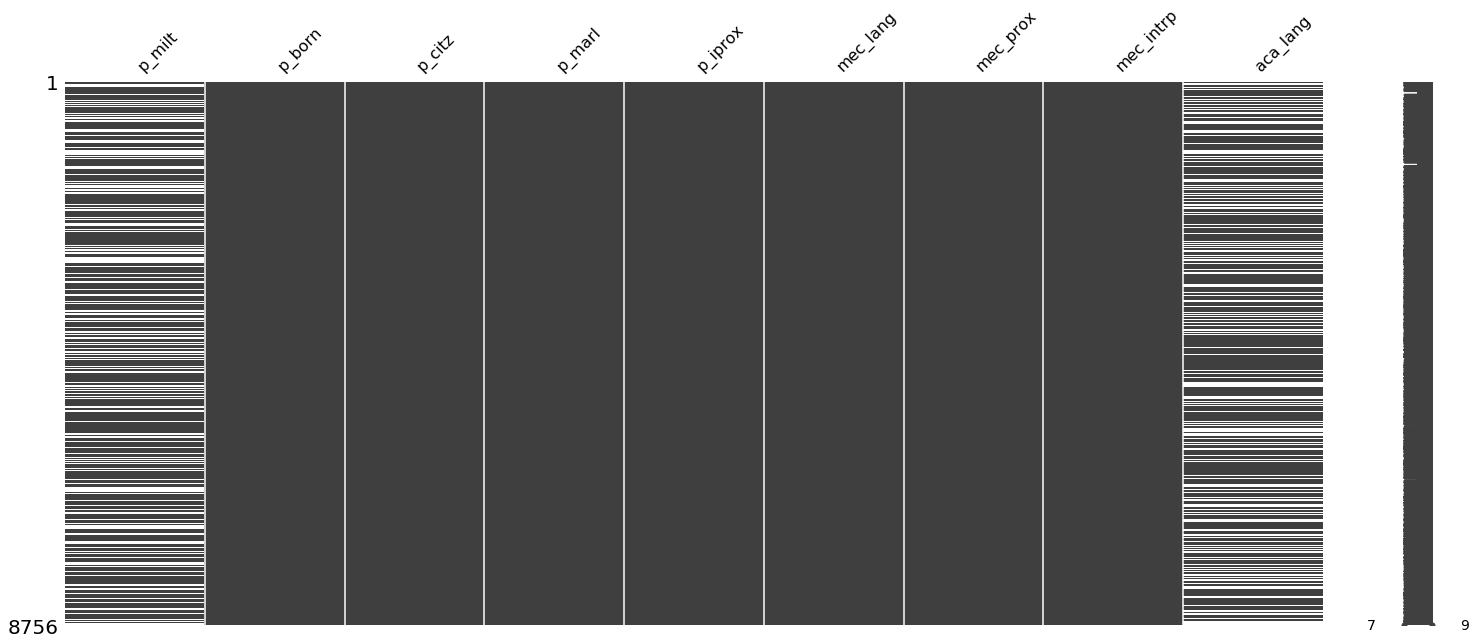

In [46]:
columns_with_na=newdf.columns[df.isna().any()].tolist()
msno.matrix(newdf[columns_with_na])

In [47]:
#look back all the columns to fill the from forward missing columns
#now do a similarity algorithm to fill those missing values
# now use previous columns to fill the front columns
dict_count_na,sorted_dict_count_na=dictcountna(newdf)
neighbours=['p_ilang','p_iprox','p_intrp','p_born','p_gen','mec_lang','mec_prox','mec_intrp']
variable ='aca_lang'
newdf=neighbours_similarity(neighbours,variable,newdf,dict_count_na)


2 aca_lan_int_eng
5 aca_lan_int_spa
7 aca_lan_int_eng
14 aca_lan_int_eng
16 aca_lan_int_eng
27 aca_lan_int_eng
29 aca_lan_int_eng
30 aca_lan_int_eng
38 aca_lan_int_eng
39 aca_lan_int_eng
42 aca_lan_int_eng
43 aca_lan_int_asi
46 aca_lan_int_eng
51 aca_lan_int_eng
56 aca_lan_int_eng
57 aca_lan_int_eng
60 aca_lan_int_eng
61 aca_lan_int_eng
64 aca_lan_int_eng
66 aca_lan_int_eng
67 aca_lan_int_eng
68 aca_lan_int_eng
70 aca_lan_int_eng
71 aca_lan_int_eng
73 aca_lan_int_eng
75 aca_lan_int_eng
76 aca_lan_int_eng
83 aca_lan_int_spa
85 aca_lan_int_eng
86 aca_lan_int_eng
88 aca_lan_int_spa
89 aca_lan_int_asi
91 aca_lan_int_eng
108 aca_lan_int_eng
113 aca_lan_int_eng
116 aca_lan_int_eng
122 aca_lan_int_eng
126 aca_lan_int_eng
135 aca_lan_int_eng
136 aca_lan_int_spa
138 aca_lan_int_eng
141 aca_lan_int_asi
143 aca_lan_int_eng
144 aca_lan_int_eng
147 aca_lan_int_eng
149 aca_lan_int_eng
153 aca_lan_int_eng
155 aca_lan_int_eng
165 aca_lan_int_eng
166 aca_lan_int_asi
168 aca_lan_int_eng
172 aca_lan_int_

1407 aca_lan_int_eng
1411 aca_lan_int_eng
1413 aca_lan_int_asi
1419 aca_lan_int_eng
1425 aca_lan_int_eng
1435 aca_lan_int_eng
1437 aca_lan_int_eng
1439 aca_lan_int_eng
1441 aca_lan_int_eng
1444 aca_lan_int_eng
1449 aca_lan_int_eng
1461 aca_lan_int_eng modeused
1463 aca_lan_int_eng
1465 aca_lan_int_eng
1473 aca_lan_int_spa
1474 aca_lan_int_eng
1477 aca_lan_int_eng
1482 aca_lan_int_spa
1484 aca_lan_int_eng
1489 aca_lan_int_eng
1494 aca_lan_int_spa
1495 aca_lan_int_eng
1497 aca_lan_int_eng modeused
1500 aca_lan_int_eng
1504 aca_lan_int_eng
1507 aca_lan_int_eng
1509 aca_lan_int_eng
1511 aca_lan_int_eng
1518 aca_lan_int_eng
1519 aca_lan_int_eng
1521 aca_lan_int_eng
1525 aca_lan_int_eng
1526 aca_lan_int_eng
1530 aca_lan_int_eng
1532 aca_lan_int_eng
1533 aca_lan_int_eng
1539 aca_lan_int_eng
1542 aca_lan_int_eng
1543 aca_lan_int_eng
1554 aca_lan_int_spa
1558 aca_lan_int_eng
1567 aca_lan_int_eng
1568 aca_lan_int_eng
1571 aca_lan_int_eng
1575 aca_lan_int_eng modeused
1582 aca_lan_int_eng
1587 ac

2661 aca_lan_int_eng
2667 aca_lan_int_eng
2670 aca_lan_int_eng
2678 aca_lan_int_eng
2684 aca_lan_int_eng
2688 aca_lan_int_eng
2690 aca_lan_int_eng
2695 aca_lan_int_spa
2699 aca_lan_int_asi
2700 aca_lan_int_eng
2706 aca_lan_int_eng
2709 aca_lan_int_eng
2711 aca_lan_int_eng
2717 aca_lan_int_eng
2726 aca_lan_int_eng
2733 aca_lan_int_eng
2735 aca_lan_int_eng
2736 aca_lan_int_eng
2737 aca_lan_int_eng
2744 aca_lan_int_eng modeused
2745 aca_lan_int_eng
2752 aca_lan_int_eng
2753 aca_lan_int_eng
2759 aca_lan_int_eng
2760 aca_lan_int_eng
2769 aca_lan_int_eng
2774 aca_lan_int_eng modeused
2776 aca_lan_int_eng
2777 aca_lan_int_eng
2779 aca_lan_int_eng
2780 aca_lan_int_eng
2789 aca_lan_int_eng
2791 aca_lan_int_eng
2792 aca_lan_int_eng
2795 aca_lan_int_eng
2796 aca_lan_int_eng
2802 aca_lan_int_eng
2806 aca_lan_int_eng
2811 aca_lan_int_asi
2813 aca_lan_int_asi
2824 aca_lan_int_eng
2831 aca_lan_int_eng
2832 aca_lan_int_eng
2834 aca_lan_int_eng
2835 aca_lan_int_eng
2838 aca_lan_int_asi
2840 aca_lan_int

4007 aca_lan_int_eng
4009 aca_lan_int_eng
4010 aca_lan_int_eng
4020 aca_lan_int_eng
4026 aca_lan_int_spa
4029 aca_lan_int_eng
4030 aca_lan_int_eng
4032 aca_lan_int_eng
4034 aca_lan_int_eng
4036 aca_lan_int_eng
4042 aca_lan_int_eng
4045 aca_lan_int_eng
4046 aca_lan_int_eng
4051 aca_lan_int_eng
4053 aca_lan_int_eng
4054 aca_lan_int_eng
4062 aca_lan_int_eng
4063 aca_lan_int_eng
4068 aca_lan_int_eng
4069 aca_lan_int_eng
4072 aca_lan_int_eng
4073 aca_lan_int_eng
4074 aca_lan_int_eng
4079 aca_lan_int_asi
4085 aca_lan_int_eng
4087 aca_lan_int_eng
4088 aca_lan_int_eng
4091 aca_lan_int_eng
4094 aca_lan_int_eng
4095 aca_lan_int_eng
4099 aca_lan_int_eng
4104 aca_lan_int_spa
4108 aca_lan_int_eng
4111 aca_lan_int_eng
4114 aca_lan_int_eng
4116 aca_lan_int_eng
4120 aca_lan_int_eng
4127 aca_lan_int_eng
4128 aca_lan_int_eng
4131 aca_lan_int_eng
4137 aca_lan_int_eng
4143 aca_lan_int_eng
4151 aca_lan_int_eng
4158 aca_lan_int_eng
4161 aca_lan_int_asi
4162 aca_lan_int_eng
4168 aca_lan_int_spa
4171 aca_lan_

5313 aca_lan_int_asi
5317 aca_lan_int_eng
5326 aca_lan_int_eng
5330 aca_lan_int_eng
5332 aca_lan_int_eng
5333 aca_lan_int_spa
5347 aca_lan_int_asi
5348 aca_lan_int_eng
5353 aca_lan_int_eng
5358 aca_lan_int_eng
5360 aca_lan_int_eng
5366 aca_lan_int_eng
5375 aca_lan_int_eng
5376 aca_lan_int_spa
5381 aca_lan_int_eng
5382 aca_lan_int_eng
5387 aca_lan_int_eng
5389 aca_lan_int_eng
5400 aca_lan_int_eng
5405 aca_lan_int_eng
5406 aca_lan_int_eng
5412 aca_lan_int_eng
5420 aca_lan_int_eng
5423 aca_lan_int_eng
5424 aca_lan_int_eng
5425 aca_lan_int_eng
5428 aca_lan_int_spa
5429 aca_lan_int_eng
5433 aca_lan_int_eng
5439 aca_lan_int_eng
5441 aca_lan_int_eng
5443 aca_lan_int_eng
5450 aca_lan_int_eng
5451 aca_lan_int_eng
5455 aca_lan_int_eng
5456 aca_lan_int_eng
5460 aca_lan_int_eng
5463 aca_lan_int_asi
5468 aca_lan_int_eng
5471 aca_lan_int_eng
5475 aca_lan_int_eng
5478 aca_lan_int_eng
5481 aca_lan_int_eng
5482 aca_lan_int_eng
5486 aca_lan_int_eng
5487 aca_lan_int_eng
5493 aca_lan_int_eng
5497 aca_lan_

6591 aca_lan_int_eng
6595 aca_lan_int_eng
6599 aca_lan_int_eng
6605 aca_lan_int_eng
6610 aca_lan_int_eng
6614 aca_lan_int_eng
6617 aca_lan_int_eng
6633 aca_lan_int_spa
6635 aca_lan_int_eng
6637 aca_lan_int_eng
6638 aca_lan_int_eng
6640 aca_lan_int_asi
6642 aca_lan_int_eng
6643 aca_lan_int_eng
6650 aca_lan_int_eng
6651 aca_lan_int_eng
6653 aca_lan_int_eng
6658 aca_lan_int_eng
6660 aca_lan_int_eng
6663 aca_lan_int_spa
6665 aca_lan_int_eng
6666 aca_lan_int_eng
6667 aca_lan_int_eng
6670 aca_lan_int_eng
6671 aca_lan_int_eng
6672 aca_lan_int_eng
6677 aca_lan_int_eng
6680 aca_lan_int_eng
6686 aca_lan_int_eng
6687 aca_lan_int_eng
6690 aca_lan_int_eng
6691 aca_lan_int_eng
6692 aca_lan_int_eng
6694 aca_lan_int_eng
6697 aca_lan_int_eng
6698 aca_lan_int_eng
6699 aca_lan_int_spa
6700 aca_lan_int_eng
6702 aca_lan_int_eng
6709 aca_lan_int_eng
6710 aca_lan_int_eng
6711 aca_lan_int_spa
6712 aca_lan_int_eng
6713 aca_lan_int_eng
6714 aca_lan_int_eng
6718 aca_lan_int_eng
6720 aca_lan_int_eng
6721 aca_lan_

7922 aca_lan_int_eng
7927 aca_lan_int_eng
7929 aca_lan_int_eng
7932 aca_lan_int_eng
7933 aca_lan_int_eng
7936 aca_lan_int_eng
7939 aca_lan_int_spa
7945 aca_lan_int_spa
7947 aca_lan_int_eng
7948 aca_lan_int_eng
7949 aca_lan_int_eng
7951 aca_lan_int_eng
7962 aca_lan_int_eng
7963 aca_lan_int_spa
7968 aca_lan_int_eng
7973 aca_lan_int_eng
7974 aca_lan_int_eng
7976 aca_lan_int_eng
7978 aca_lan_int_eng
7979 aca_lan_int_eng
7980 aca_lan_int_spa
7984 aca_lan_int_eng
7986 aca_lan_int_eng
7993 aca_lan_int_eng
7995 aca_lan_int_eng
8000 aca_lan_int_eng
8003 aca_lan_int_eng
8010 aca_lan_int_eng
8015 aca_lan_int_eng
8017 aca_lan_int_eng
8019 aca_lan_int_asi
8022 aca_lan_int_eng modeused
8025 aca_lan_int_eng
8027 aca_lan_int_eng
8029 aca_lan_int_eng
8032 aca_lan_int_eng
8037 aca_lan_int_eng
8039 aca_lan_int_eng
8043 aca_lan_int_spa
8048 aca_lan_int_eng
8050 aca_lan_int_eng
8051 aca_lan_int_eng
8054 aca_lan_int_eng
8056 aca_lan_int_eng
8060 aca_lan_int_eng
8062 aca_lan_int_eng
8066 aca_lan_int_eng
8073

9245 aca_lan_int_eng
9246 aca_lan_int_eng
9248 aca_lan_int_eng
9252 aca_lan_int_eng
9253 aca_lan_int_eng
9260 aca_lan_int_eng
9261 aca_lan_int_eng
9262 aca_lan_int_eng
9267 aca_lan_int_eng
9269 aca_lan_int_eng
9277 aca_lan_int_eng
9282 aca_lan_int_asi
9283 aca_lan_int_eng modeused
9285 aca_lan_int_eng
9289 aca_lan_int_eng
9290 aca_lan_int_eng
9291 aca_lan_int_eng
9292 aca_lan_int_eng
9296 aca_lan_int_eng
9297 aca_lan_int_eng
9298 aca_lan_int_eng
9307 aca_lan_int_spa
9308 aca_lan_int_eng
9309 aca_lan_int_eng
9312 aca_lan_int_eng
9313 aca_lan_int_eng
9315 aca_lan_int_eng
9317 aca_lan_int_eng
9318 aca_lan_int_eng
9321 aca_lan_int_eng
9323 aca_lan_int_spa
9324 aca_lan_int_eng
9326 aca_lan_int_eng
9327 aca_lan_int_eng
9328 aca_lan_int_asi
9337 aca_lan_int_eng
9338 aca_lan_int_eng
9341 aca_lan_int_eng
9349 aca_lan_int_spa
9352 aca_lan_int_eng
9359 aca_lan_int_spa
9363 aca_lan_int_spa
9366 aca_lan_int_eng modeused
9374 aca_lan_int_eng
9382 aca_lan_int_asi
9386 aca_lan_int_eng
9387 aca_lan_int

In [48]:
#look back all the columns to fill the from forward missing columns
#now do a similarity algorithm to fill those missing values
# now use previous columns to fill the front columns
dict_count_na,sorted_dict_count_na=dictcountna(newdf)
neighbours=['p_ilang','p_iprox','p_intrp','p_born','p_gen']
variable ='p_milt'
newdf=neighbours_similarity(neighbours,variable,newdf,dict_count_na)


6 mil_no
7 mil_no
13 mil_no
14 mil_no
16 mil_no
19 mil_no
21 mil_no
24 mil_no
27 mil_no
30 mil_no
31 mil_no
33 mil_no
35 mil_no
37 mil_no
38 mil_no
40 mil_no
44 mil_no
46 mil_no
57 mil_no
58 mil_no
60 mil_no
61 mil_no
65 mil_no
70 mil_no
71 mil_no
72 mil_no modeused
73 mil_no
75 mil_no
76 mil_no
79 mil_no
80 mil_no
84 mil_no
90 mil_no
91 mil_no
95 mil_no
96 mil_no
98 mil_no
100 mil_no
103 mil_no
104 mil_no
106 mil_no
112 mil_no
118 mil_no
122 mil_no
126 mil_no
129 mil_no
130 mil_no
135 mil_no
139 mil_no
140 mil_no
143 mil_no
149 mil_no
153 mil_no
156 mil_no modeused
161 mil_no
164 mil_no
165 mil_no
175 mil_no
177 mil_no
180 mil_no
187 mil_no
194 mil_no
198 mil_no
205 mil_no modeused
209 mil_no
217 mil_no
225 mil_no
227 mil_no
229 mil_no
235 mil_no
236 mil_no
237 mil_no
238 mil_no
240 mil_no
247 mil_no
253 mil_no
260 mil_no
264 mil_no
268 mil_no
272 mil_no
278 mil_no
281 mil_no
288 mil_no
296 mil_no
300 mil_no
303 mil_no
307 mil_no
308 mil_no
310 mil_no
314 mil_no
317 mil_no
327 mil_no


2359 mil_no
2364 mil_no modeused
2365 mil_no
2368 mil_no
2370 mil_no
2372 mil_no
2373 mil_no
2377 mil_no
2388 mil_no
2392 mil_no
2393 mil_no
2396 mil_no
2397 mil_no
2398 mil_no
2403 mil_no
2411 mil_no
2413 mil_no
2414 mil_no
2415 mil_no
2416 mil_no
2417 mil_no
2419 mil_no modeused
2420 mil_no
2426 mil_no
2427 mil_no
2430 mil_no
2434 mil_no
2443 mil_no
2449 mil_no
2452 mil_no
2454 mil_no
2461 mil_no
2463 mil_no
2464 mil_no
2465 mil_no
2468 mil_no
2471 mil_no
2472 mil_no
2474 mil_no modeused
2484 mil_no
2487 mil_no
2494 mil_no
2497 mil_no
2498 mil_no
2501 mil_no
2502 mil_no
2510 mil_no
2512 mil_no
2520 mil_no
2526 mil_no
2527 mil_no
2530 mil_no
2531 mil_no
2532 mil_no
2533 mil_no
2535 mil_no
2537 mil_no
2538 mil_no
2541 mil_no
2543 mil_no
2544 mil_no
2545 mil_no
2546 mil_no
2547 mil_no
2554 mil_no
2563 mil_no
2566 mil_no
2568 mil_no
2575 mil_no
2577 mil_no
2578 mil_no modeused
2579 mil_no modeused
2583 mil_no
2585 mil_no
2587 mil_no
2590 mil_no
2593 mil_no
2595 mil_no
2597 mil_no
2603 mi

4436 mil_no
4437 mil_no
4441 mil_no
4442 mil_no
4445 mil_no
4446 mil_no
4453 mil_no
4454 mil_no
4457 mil_no
4459 mil_no
4466 mil_no
4475 mil_no
4476 mil_no
4479 mil_no
4480 mil_no
4483 mil_no
4494 mil_no
4496 mil_no
4501 mil_no modeused
4502 mil_no
4508 mil_no
4511 mil_no
4513 mil_no
4515 mil_no
4517 mil_no
4522 mil_no
4524 mil_no
4525 mil_no
4526 mil_no modeused
4529 mil_no
4530 mil_no modeused
4531 mil_no
4535 mil_no modeused
4543 mil_no
4546 mil_no
4547 mil_no modeused
4548 mil_no
4549 mil_no
4551 mil_no modeused
4554 mil_no
4555 mil_no
4556 mil_no
4558 mil_no
4561 mil_no
4562 mil_no
4564 mil_no
4566 mil_no
4567 mil_no
4568 mil_no
4572 mil_no
4574 mil_no
4575 mil_no
4577 mil_no
4586 mil_no
4588 mil_no
4589 mil_no modeused
4593 mil_no
4595 mil_no
4600 mil_no
4604 mil_no
4608 mil_no
4609 mil_no
4611 mil_no
4612 mil_no
4614 mil_no
4617 mil_no
4618 mil_no
4621 mil_no
4623 mil_no
4627 mil_no
4631 mil_no
4634 mil_no
4639 mil_no
4647 mil_no
4648 mil_no
4662 mil_no modeused
4668 mil_no
4671

6534 mil_no
6536 mil_no
6544 mil_no
6545 mil_no
6546 mil_no
6552 mil_no
6554 mil_no
6557 mil_no
6560 mil_no
6561 mil_no
6565 mil_no
6566 mil_no
6568 mil_no
6574 mil_no
6578 mil_no
6579 mil_no
6582 mil_no
6583 mil_no
6585 mil_no
6591 mil_no modeused
6592 mil_no
6599 mil_no
6603 mil_no
6605 mil_no
6610 mil_no
6619 mil_no
6622 mil_no
6624 mil_no
6629 mil_no
6642 mil_no
6643 mil_no
6645 mil_no
6647 mil_no modeused
6654 mil_no
6656 mil_no
6658 mil_no
6660 mil_no
6665 mil_no
6666 mil_no
6667 mil_no
6669 mil_no
6670 mil_no
6673 mil_no
6675 mil_no
6677 mil_no
6678 mil_no
6684 mil_no
6686 mil_no
6689 mil_no
6690 mil_no
6691 mil_no modeused
6694 mil_no
6696 mil_no
6697 mil_no
6698 mil_no
6700 mil_no
6702 mil_no
6709 mil_no
6710 mil_no
6712 mil_no
6715 mil_no
6718 mil_no
6720 mil_no
6721 mil_no
6722 mil_no
6724 mil_no
6728 mil_no
6732 mil_no
6733 mil_no
6736 mil_no
6737 mil_no
6738 mil_no
6739 mil_no
6740 mil_no
6743 mil_no
6745 mil_no
6749 mil_no
6750 mil_no
6757 mil_no
6759 mil_no
6764 mil_no
6

8502 mil_no
8507 mil_no
8515 mil_no
8516 mil_no
8518 mil_no
8521 mil_no
8526 mil_no
8528 mil_no
8531 mil_no
8534 mil_no
8541 mil_no
8543 mil_no
8546 mil_no
8548 mil_no
8553 mil_no
8557 mil_no
8566 mil_no
8567 mil_no
8568 mil_no
8570 mil_no
8572 mil_no
8580 mil_no
8587 mil_no
8593 mil_no modeused
8596 mil_no
8597 mil_no
8598 mil_no
8599 mil_no
8601 mil_no
8604 mil_no
8607 mil_no
8609 mil_no
8615 mil_no
8622 mil_no modeused
8624 mil_no
8625 mil_no
8632 mil_no
8634 mil_no
8639 mil_no
8640 mil_no
8641 mil_no
8643 mil_no
8644 mil_no
8647 mil_no
8649 mil_no
8650 mil_no
8659 mil_no
8661 mil_no
8663 mil_no
8664 mil_no
8666 mil_no
8669 mil_no
8675 mil_no
8677 mil_no
8679 mil_no
8681 mil_no
8682 mil_no
8684 mil_no
8687 mil_no modeused
8688 mil_no
8690 mil_no modeused
8692 mil_no modeused
8694 mil_no
8711 mil_no
8714 mil_no
8718 mil_no
8723 mil_no
8724 mil_no
8725 mil_no
8732 mil_no
8733 mil_no
8742 mil_no
8743 mil_no
8744 mil_no
8745 mil_no
8746 mil_no
8747 mil_no
8752 mil_no
8755 mil_no
8757 mi

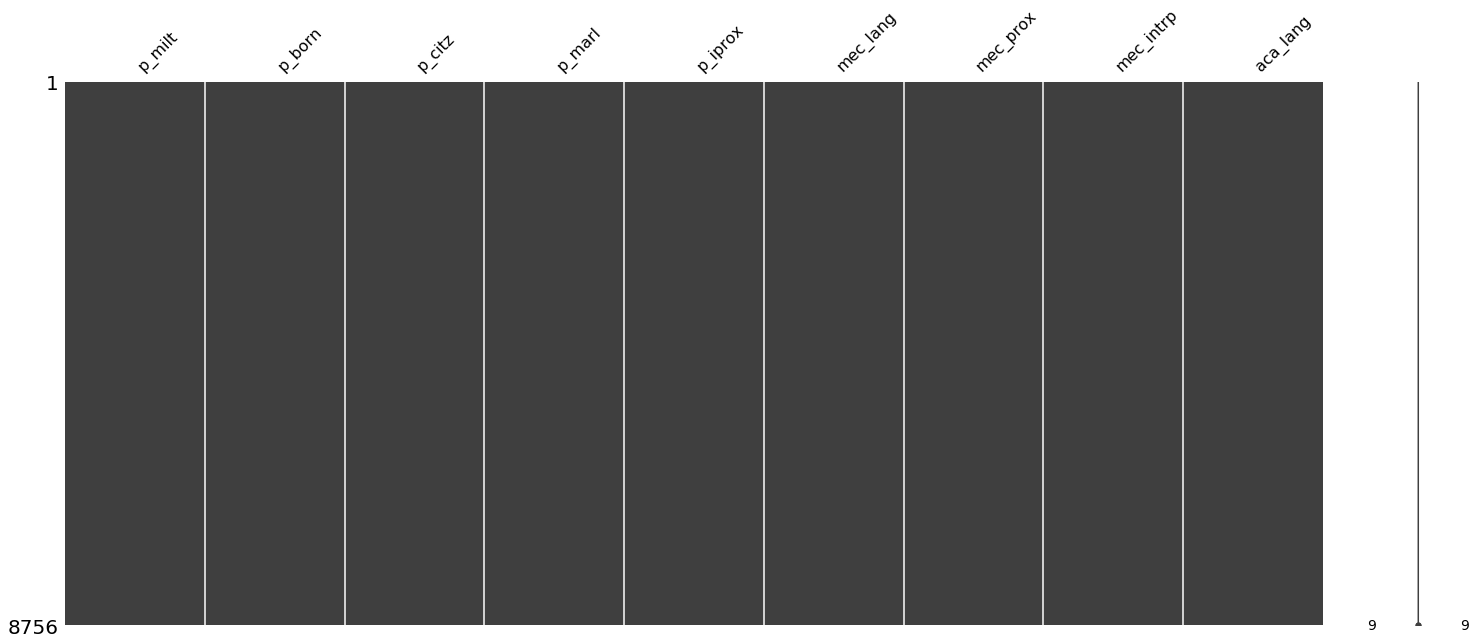

In [51]:
columns_with_na=newdf.columns[df.isna().any()].tolist()
msno.matrix(newdf[columns_with_na])

In [54]:
newdf['p_milt'].value_counts()

mil_no     8259
mil_yes     497
Name: p_milt, dtype: int64

In [55]:
%store newdf

Stored 'newdf' (DataFrame)
